In [1]:
using Random, Statistics, PyPlot

In [2]:
function DiagUpdate!(s::Vector{Int64}, c::Vector{Int64}, T::Float64)
    # s is the operator string, c is the spin configuration at p=0

    Nmax = length(s) # total length of operator string
    n = sum(s .> 0) # number of non-identity operators in the string
    
    Nb = length(c) # this is the number of bonds assuming periodic boundary conditions
    
    for p in range(1, stop = Nmax)
        if s[p] == 0 # identity operator present at this p, attempt adding diagonal H term
            
            # pick a random bond and attempt inserting diag H if the spins are anti-parallel
            b = rand(1:Nb)
            
            i, j = b, mod(b, length(c))+1 
            if c[i] == c[j]
                continue
            end
            
            p_insert = Nb/(2*T*(Nmax-n))
            if rand() < p_insert
                n += 1
                s[p] = 2*b-1
            end
            
        elseif mod(s[p],2) == 1 # diagonal operator present at this p, attempt removal
            p_remove = 2*T*( Nmax - (n-1) )/Nb
            if rand() < p_remove
                n -= 1
                s[p] = 0
            end
        else # off-diagonal operator present at this p
            # keep track of the spin configuration after each p
            b = div(s[p],2)
            i, j = b, mod(b, length(c))+1 
            c[i], c[j] = 1-c[i], 1-c[j]
        end
    end
end

DiagUpdate! (generic function with 1 method)

In [3]:
function LinkedVertexList(s::Vector{Int64}, Nx::Int64)
    
    Nmax = length(s)
    
    list = zeros(Int64, 4*Nmax)
    
    lastVertex = zeros(Int64, Nx) # store the last vertex for each site
    firstVertex = zeros(Int64, Nx) # store the first vertex for each site
    
    for p in range(1, length = Nmax)

        if s[p] == 0 # no vertices here
            continue
        end

        b = div(s[p]+1,2) # bond index
        i, j = b, mod(b, Nx)+1 # site indices
        
        vi, vj = lastVertex[i], lastVertex[j]
        if vi != 0
            list[vi] = 4*(p-1)+1
            list[4*(p-1)+1] = vi
        else
            firstVertex[i] = 4*(p-1)+1
        end
                    
        if vj != 0
            list[vj] = 4*(p-1)+2
            list[4*(p-1)+2] = vj
        else
            firstVertex[j] = 4*(p-1)+2
        end
            
        # update last vertex for each site
        lastVertex[i], lastVertex[j] = 4*(p-1)+3, 4*(p-1)+4
                
    end

    # link back last to first (due to periodic boundary conditions in p)
    for i in range(1, length=Nx)
        if firstVertex[i] != 0
            list[lastVertex[i]] = firstVertex[i]
            list[firstVertex[i]] = lastVertex[i]
        end
    end
    
    # return the linked vertices list, and also all the sites that didn't appear in any vertex
    return list, firstVertex
    
end

LinkedVertexList (generic function with 1 method)

In [4]:
function TraverseLoop!(v0::Int64, list::Vector{Int64}, s::Vector{Int64}, flip::Bool = false )
  
    v = v0
    
    while true
        if flip
            p = div(v-1,4)+1 # find p at which this vertex lives, reacall that both v and p are 1-based
            b = div(s[p]+1,2) # bond index corresponding to this vertex
            op_type = mod(s[p],2) # diagonal or off-diagonal
            s[p] = 2*b - (1-op_type) # flip diagonal <-> off-diagonal
        end
        list[v] = flip ? -1 : 0
        vn = mod(v,2) == 1 ? v+1 : v-1
        next_v = list[vn]
        list[vn] = flip ? -1 : 0

        if next_v == v0
            break
        else
            v = next_v
        end
    end
    
end

function LoopUpdate!(s::Vector{Int64}, c::Vector{Int64}, list::Vector{Int64}, first::Vector{Int64})
    
    for v in range(1, stop = length(list), step = 2) # neighboring vertices are always treated together
        if list[v] <= 0 # this vertex has already been visited
            continue
        end
        
        
        # traverse the loop and flip the spins along the loop with p=1/2
        if rand() < 0.5
            TraverseLoop!(v, list, s, false)
        else
            TraverseLoop!(v, list, s, true)
        end
        
    end
    
    # update the spin configuration at p=0
    for i in range(1, length = length(first))
        if first[i] == 0
            c[i]  = rand() < 0.5 ? c[i] : 1-c[i]
        elseif list[first[i]] == -1
            c[i] = 1-c[i]
        end
    end
    
end

LoopUpdate! (generic function with 1 method)

In [5]:
function HeisenbergSSE(Nx::Int64, T::Float64, Nsw::Int64)
    
    n0 = 100 # initial operator string length
    s = zeros(Int64, n0) # initial operator string - all identities
    c = rand(0:1, Nx) # initial spin configuration
    
    ns = zeros(Nsw)
    
    for i in range(1, length=Nsw)
        DiagUpdate!(s, copy(c), T)
        list, first = LinkedVertexList(s, Nx)
        LoopUpdate!(s, c, list, first)
            
        @assert sum(list .> 0) == 0 "Some vertices have not been visited!" 
        
        # check if length of operators string needs to be increased
        ns[i] = sum(s .> 0)
        Nmax = length(s)
        if ns[i] > Nmax * 3/4
            new_Nmax = Int(ceil(Nmax * 4/3))
            println("Increasing Nmax to ", new_Nmax)
            # increase length of operator string by padding with identity operators
            old_s = copy(s)
            s = zeros(Int64, new_Nmax)
            s[1:Nmax] = old_s[1:Nmax]
        end
    end
        
    return ns
    
end

HeisenbergSSE (generic function with 1 method)

In [6]:
function CalculateError(obs, Neq, Nsw)
    # obs is the vector of measurements for the observable
    err = Float64[]
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than number of sweeps after equilibration
    obs_l = obs[end-Nsw2+1:end]
    min_size = 2^5
    while length(obs_l) > min_size
        push!(err, std(obs_l)/sqrt(length(obs_l)-1))
        obs_l = map(j -> mean(obs_l[2*j-1:2*j]), range(1,stop=div(length(obs_l),2)) )
    end
    return err
end

CalculateError (generic function with 1 method)

In [14]:
Nx = 10
T = 1e-3
Nsw = 1000
@time ns = HeisenbergSSE(Nx, T, Nsw);

Increasing Nmax to 134
Increasing Nmax to 179
Increasing Nmax to 239
Increasing Nmax to 319
Increasing Nmax to 426
Increasing Nmax to 568
Increasing Nmax to 758
Increasing Nmax to 1011
Increasing Nmax to 1348
Increasing Nmax to 1798
Increasing Nmax to 2398
Increasing Nmax to 3198
Increasing Nmax to 4264
Increasing Nmax to 5686
Increasing Nmax to 7582
Increasing Nmax to 10110
  0.556150 seconds (14.85 k allocations: 325.214 MiB, 10.39% gc time)


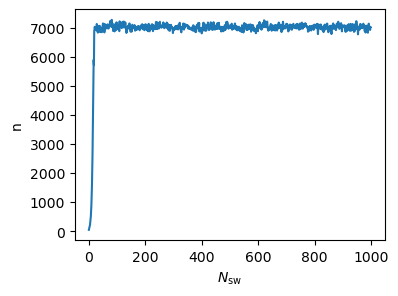

In [15]:
figure(figsize=(4,3))
plot(ns)
ylabel("n")
xlabel(L"$N_{\rm sw}$");

In [16]:
Neq = 100
mean_n = mean(ns[Neq:Nsw])
dn = CalculateError(ns, Neq, Nsw)[end]

Egs_mc = -T*mean(ns[Neq:Nsw])+1/4*Nx
dE = dn*T

Egs_exact = -4.515446

println("Ground state energy obtained using QMC is ", round(Egs_mc,digits=4) , " +- ", round(dE,digits=4))
println("Error compared to ED ", round(Egs_mc-Egs_exact,digits=4))

Ground state energy obtained using QMC is -4.516 +- 0.0052
Error compared to ED -0.0005
